In [1]:
import sys
sys.path.append('../')

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.decomposition import PCA
from low_rank_rnns.modules import *
from low_rank_rnns import rdm, clustering, helpers, rankone

In [2]:
helpers.setup_matplotlib(release=True)
cmap = sns.diverging_palette(255, 133, l=50, s=75, n=12)
col1 = np.array([237, 144, 10]) / 255
col2 = np.array([116, 134, 190]) / 255
col_stim_period = 'silver'
col_response_period = 'sandybrown'

In [3]:
def time_mapping(t):
    return t * rdm.deltaT / 1000

In [4]:
hidden_size = 512
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = rdm.generate_rdm_data(1000)
net = LowRankRNN(1, hidden_size, 1, noise_std, alpha, train_wi=False, train_wo=False, rank=1)
net.load_state_dict(torch.load(f'../models/rdm_rank1_{hidden_size}.pt', map_location='cpu'))

In [5]:
loss_orig, acc_orig = rdm.test_rdm(net, x_val, y_val, mask_val)

In [6]:
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi = net.wi_full[0].detach().numpy()
wo = net.wo_full[:,0].detach().numpy()

# Traces

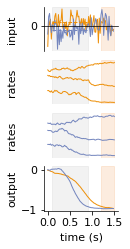

In [7]:
coh1 = .6
coh2 = -.6
net.noise_std = noise_std

# Generate data and network response
x1, y1, mask1, _, _, _ = rdm.generate_rdm_data(1, coherences=[coh1], fraction_validation_trials=0.)
x2, y2, mask2, _, _, _ = rdm.generate_rdm_data(1, coherences=[coh2], fraction_validation_trials=0.)
outp1, trajectories = net.forward(x1, return_dynamics=True)
trajectories = trajectories.detach().numpy().squeeze()
rates1 = np.tanh(trajectories)
outp2, trajectories = net.forward(x2, return_dynamics=True)
trajectories = trajectories.detach().numpy().squeeze()
rates2 = np.tanh(trajectories)
outp1 = outp1.detach().squeeze().numpy()
outp2 = outp2.detach().squeeze().numpy()

# Task epochs
task_len = x1.shape[1]
stim_beg = rdm.fixation_duration_discrete
stim_end = rdm.stimulus_end
decision_beg = rdm.response_begin
time = time_mapping(np.arange(task_len))

default_figsize = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(4, 1, figsize=(2.5 * .7 * .75, 2.5 * 2 * .75))

# input
x1 = x1.squeeze().numpy()
x2 = x2.squeeze().numpy()
ax[0].plot(time, x1, c=col1)
ax[0].plot(time, x2, c=col2)
ax[0].plot(time[stim_beg:stim_end], [coh1 * rdm.SCALE / 100] * (stim_end - stim_beg), ls='--', c=col1)
ax[0].plot(time[stim_beg:stim_end], [coh2 * rdm.SCALE / 100] * (stim_end - stim_beg), ls='--', c=col2)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_position('zero')
ax[0].axvspan(time_mapping(stim_beg), time_mapping(stim_end), alpha=.2, color=col_stim_period)
ax[0].axvspan(time_mapping(decision_beg), time_mapping(task_len), alpha=.2, color=col_response_period)
ax[0].set(yticks=[0], xticks=[], ylabel='input')

# single neurons
n_neurons = 3
neurons = np.random.choice(hidden_size, n_neurons, replace=False)

extracted_act1 = rates1[:, neurons]
helpers.plot_rates_single_neurons(extracted_act1, offset=.3, deltaT=rdm.deltaT, colors=[col1] * n_neurons,
                                       ax=ax[1])
ax[1].axvspan(time_mapping(stim_beg), time_mapping(stim_end), alpha=.2, color=col_stim_period)
ax[1].axvspan(time_mapping(decision_beg), time_mapping(task_len), alpha=.2, color=col_response_period)
ax[1].set(ylabel='rates', yticks = [], xticks=[])
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)

extracted_act2 = rates2[:, neurons]
helpers.plot_rates_single_neurons(extracted_act2, offset=.3, deltaT=rdm.deltaT, colors=[col2] * n_neurons,
                                       ax=ax[2])
ax[2].axvspan(time_mapping(stim_beg), time_mapping(stim_end), alpha=.2, color=col_stim_period)
ax[2].axvspan(time_mapping(decision_beg), time_mapping(task_len), alpha=.2, color=col_response_period)
ax[2].set(ylabel='rates', yticks=[], xticks=[])
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)

# output
ax[3].plot(time, outp1, c=col1)
ax[3].plot(time, outp2, c=col2)
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].set(xticks=[0, .5, 1, 1.5], xlabel='time (s)', ylabel='output')
ax[3].axvspan(time_mapping(stim_beg), time_mapping(stim_end), alpha=.2, color=col_stim_period)
ax[3].axvspan(time_mapping(decision_beg), time_mapping(task_len), alpha=.2, color=col_response_period)

fig.align_ylabels()

#plt.savefig('figures/2_rdm_traces.pdf', bbox_inches='tight')

# Populations and overlaps

Text(0, 0.9, '$n_i$')

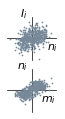

In [8]:
# Scatter n, wi and m, n
color = 'lightslategray'

figsize_default = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(2, 1, figsize=(figsize_default[0] / 2 * .7, figsize_default[1] * .7))
helpers.center_axes(ax[0])
ax[0].scatter(n, wi, c=color, s=.5, zorder=30)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-8, 8)
ax[0].set_xlabel('$n_i$', horizontalalignment='right', x=1.05)
ax[0].set_ylabel('$I_i$', horizontalalignment='right', y=.9, rotation='horizontal')

helpers.center_axes(ax[1])
ax[1].scatter(m, n, c=color, s=.5, zorder=30)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-7, 7)
ax[1].set_xlabel('$m_i$', horizontalalignment='right', x=1.)
ax[1].set_ylabel('$n_i$', horizontalalignment='right', y=.9, rotation='horizontal')

#plt.savefig('figures/2_rdm_scatters.pdf', bbox_inches='tight')


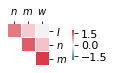

In [9]:
lsize = 10
vectors = [wi, n, m, wo]
labels = ['$I$', '$n$', '$m$ ', '$w$']
ov = helpers.overlap_matrix(vectors, triangular=True)
fig, ax = plt.subplots(figsize=(2.5 * .55, 2.5 * .55))
helpers.get_lower_tri_heatmap(ov, cbar=True, cbar_shrink=.4, cbar_pad=.3, ax=ax)
ax.set_xticks([.5, 1.5, 2.5])
ax.set_xticklabels(labels[1:])
ax.set_yticklabels(labels[:-1])
ax.xaxis.set_tick_params(labelsize=lsize)
ax.yaxis.set_tick_params(rotation=0, labelsize=lsize)
#plt.savefig('figures/2_rdm_overlap_matrix.pdf', bbox_inches='tight')

# Resampling

In [10]:
# Resample a few networks
accs = []

n_samples = 10
for _ in range(n_samples):  
    net2 = clustering.to_support_net(net, np.zeros(hidden_size))
    loss, acc = rdm.test_rdm(net2, x_val, y_val, mask_val)
    accs.append(acc)

In [11]:
# Load the reduced model
nsup = 1
dim = 2
rank = 1
net_red = SupportLowRankRNN_withMask(1, hidden_size, 1, noise_std, alpha, rank=1, n_supports=nsup, gaussian_basis_dim=dim)
net_red.load_state_dict(torch.load(f'../models/rdm_rank1_reconstructed_{hidden_size}.pt', map_location='cpu'))

accs_red = []
for _ in range(n_samples): 
    net_red.resample_basis()
    loss, acc = rdm.test_rdm(net_red, x_val, y_val, mask_val)
    accs_red.append(acc)

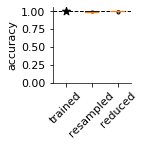

In [12]:
helpers.boxplot_accuracies([acc_orig, accs, accs_red], labels=['trained', 'resampled', 'reduced'], 
                           figsize=(2 * .7, 2 * .7))
#plt.savefig('figures/2_rdm_resampling.pdf', bbox_inches='tight')

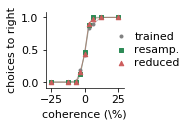

In [13]:
cohs = [-4, -2, -1, -.5, 0., .5, 1, 2, 4]
probs_trained = []
probs_reconstructed = []
probs_res = []
fig, ax = plt.subplots(1, 1, figsize=(2 * .7, 2 * .7))

# Trained net
for coh in cohs:
    input, target, mask, _, _, _ = rdm.generate_rdm_data(50, coherences=[coh], fraction_validation_trials=0)
    with torch.no_grad():
        output = net(input)
        decisions = (torch.sign(output[:, rdm.response_begin:, 0].mean(dim=1).squeeze()) + 1) // 2
        probs_trained.append(decisions.mean().item())
        
        output = net2(input)
        decisions = (torch.sign(output[:, rdm.response_begin:, 0].mean(dim=1).squeeze()) + 1) // 2
        probs_res.append(decisions.mean().item())
        
        output = net_red(input)
        decisions = (torch.sign(output[:, rdm.response_begin:, 0].mean(dim=1).squeeze()) + 1) // 2
        probs_reconstructed.append(decisions.mean().item())
        
h1 = ax.errorbar(np.array(cohs) * 100 / 16, probs_res, c='gray', ls='', marker='.', ms=6)
ax.plot(np.array(cohs) * 100 / 16, probs_res, c='gray', alpha=.5)
h2 = ax.scatter(np.array(cohs) * 100 / 16, probs_trained, c='seagreen', s=20, marker='s', zorder=30)
ax.plot(np.array(cohs) * 100 / 16, probs_trained, c='seagreen', alpha=.5)
h3 = ax.scatter(np.array(cohs) * 100 / 16, probs_reconstructed, c='indianred', marker='^', s=20, zorder=30)
ax.plot(np.array(cohs) * 100 / 16, probs_reconstructed, c='indianred', alpha=.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0., .5, 1.])
ax.set_xlabel('coherence (\%)')
ax.set_ylabel('choices to right')
ax.legend([h1, h2, h3], ['trained', 'resamp.', 'reduced'], loc='center left', frameon=False, bbox_to_anchor=(.7, .5),
         fontsize=11, labelspacing=.3, handletextpad=.2)
#plt.savefig('figures/2_rdm_psychometric_curves.pdf', bbox_inches='tight')

# Dynamics

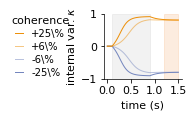

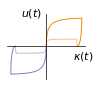

In [14]:
cohs = [-4, -1, 1, 4]
fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.2))

net.noise_std = 0
for coh in cohs:
    input_c, target_c, mask_c, _, _, _ = rdm.generate_rdm_data(1, coherences=[coh], std=0., 
                                                           fraction_validation_trials=0.)
    output_c, activations = net.forward(input_c, return_dynamics=True)
    activations = activations.detach().numpy().squeeze()
    rates = np.tanh(activations)
    kappa = rates @ n / net.hidden_size
    seq_len = input_c.shape[1] + 1
    if coh==cohs[0]:
        pl4, = ax.plot(time_mapping(np.arange(len(kappa))), kappa, c=col2)
    elif coh==cohs[1]:
        pl3, = ax.plot(time_mapping(np.arange(len(kappa))), kappa, c=col2, alpha=.5)
    elif coh==cohs[2]:
        pl2, = ax.plot(time_mapping(np.arange(len(kappa))), kappa, c=col1, alpha=.5)
    elif coh==cohs[3]:
        pl1, = ax.plot(time_mapping(np.arange(len(kappa))), kappa, c=col1)
        
# Task epochs
stim_beg = rdm.fixation_duration_discrete
stim_end = rdm.stimulus_end
decision_beg = rdm.response_begin
task_len = decision_beg + rdm.decision_duration_discrete
time = time_mapping(np.arange(task_len))

ax.axvspan(time_mapping(stim_beg), time_mapping(stim_end), alpha=.2, color=col_stim_period)
ax.axvspan(time_mapping(decision_beg), time_mapping(task_len), alpha=.2, color=col_response_period)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([0, .5, 1, 1.5])
ax.set_xlabel('time (s)')
ax.set_ylabel('internal var. $\kappa$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend([pl1, pl2, pl3, pl4], ['+25\%', '+6\%', '-6\%', '-25\%'], bbox_to_anchor=(-1.3, .5), 
          loc='center left', labelspacing=.3, handlelength=.8, title='coherence', fontsize=10)
#plt.savefig('figures/2_rdm_kappa.pdf', bbox_inches='tight')


ymin=-.7
ymax=.7
fig, ax = plt.subplots(figsize=(1.4, 1.2))
data, _, _, _, _, _ = rdm.generate_rdm_data(1, [1], 0, 0)
pl2 = rankone.plot_trial_averaged_trajectory(net, data, wi, ax, c=col1, alpha=.5)
data, _, _, _, _, _ = rdm.generate_rdm_data(1, [4], 0, 0)
pl1 = rankone.plot_trial_averaged_trajectory(net, data, wi, ax, c=col1)
data, _, _, _, _, _ = rdm.generate_rdm_data(1, [-1], 0, 0)
pl3 = rankone.plot_trial_averaged_trajectory(net, data, wi, ax, c=col2, alpha=.5)
data, _, _, _, _, _ = rdm.generate_rdm_data(1, [-4], 0, 0)
pl4 = rankone.plot_trial_averaged_trajectory(net, data, wi, ax, c=col2)
ax.set_ylim(ymin, ymax)
helpers.center_axes(ax)
ax.set_xlabel('$\kappa(t)$', horizontalalignment='right', x=1.1)
ax.set_ylabel('$u(t)$', horizontalalignment='right', y=.9, rotation=0)

net.noise_std = noise_std
#plt.savefig('figures/2_rdm_dynamics.pdf', bbox_inches='tight')

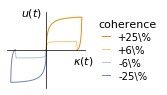

In [15]:
ymin=-.7
ymax=.7

fig, ax = plt.subplots(figsize=(1.4, 1.4))
net.noise_std = 0.
data, _, _, _, _, _ = rdm.generate_rdm_data(1, [1], 0, 0)
pl2 = rankone.plot_trial_averaged_trajectory(net, data, wi, ax, c=col1, alpha=.5)
data, _, _, _, _, _ = rdm.generate_rdm_data(1, [4], 0, 0)
pl1 = rankone.plot_trial_averaged_trajectory(net, data, wi, ax, c=col1)
data, _, _, _, _, _ = rdm.generate_rdm_data(1, [-1], 0, 0)
pl3 = rankone.plot_trial_averaged_trajectory(net, data, wi, ax, c=col2, alpha=.5)
data, _, _, _, _, _ = rdm.generate_rdm_data(1, [-4], 0, 0)
pl4 = rankone.plot_trial_averaged_trajectory(net, data, wi, ax, c=col2)
ax.set_ylim(ymin, ymax)

helpers.center_axes(ax)
ax.set_xlabel('$\kappa(t)$', horizontalalignment='right', x=1.1)
ax.set_ylabel('$u(t)$', horizontalalignment='right', y=.9, rotation=0)
ax.legend([pl1, pl2, pl3, pl4], ['+25\%', '+6\%', '-6\%', '-25\%'], bbox_to_anchor=(1.05, .5), 
          loc='center left', labelspacing=.3, handlelength=.8, title='coherence', fontsize=10)
net.noise_std = noise_std
#plt.savefig('figures/2_rdm_trajectories.pdf', bbox_inches='tight')